In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.cluster import GaussianCluster as GMM

from proglearn import LifelongClassificationForest as l2f

from graspy.embed import ClassicalMDS as CMDS

import time
from tqdm import tqdm

from joblib import Parallel, delayed

from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import pairwise_distances

In [10]:
def generate_hierarchical_gaussian_data(dist_means=None, n_clusts=2, n_dists_per_clust=2, d=2, clust_cov=1, n_per_dist=25, dist_cov=0.5, acorn=None):
    all_means = [
        np.array([1,1]),
        np.array([-1,-1]),
        np.array([1, -1]),
        np.array([-1, 1])
    ]
    
    clust_means = all_means[:n_clusts]
    clust_cov = clust_cov * np.eye(d)
    
    if dist_means is None:
        dist_means = [np.random.multivariate_normal(clust_means[i], clust_cov, size=n_dists_per_clust) for i in range(n_clusts)]
    else:
        n_clusts = len(dist_means)
        n_dists_per_clust, d = dist_means[0].shape
        
    dist_cov = dist_cov * np.eye(d)
    
    data = [
        [np.random.multivariate_normal(dist_means[i][j], dist_cov, size=n_per_dist) for j in range(n_dists_per_clust)] 
            for i in range(n_clusts)
    ]
            
    return dist_means, data

def generate_dist_matrix(data, dissimilarity = 'task-sim', acorn=None):        
    n_dists = len(data)    
    labels = [i*np.ones(data[i].shape[0]) for i in range(n_dists)]
        
    distances = np.zeros((n_dists, n_dists))
    
    if dissimilarity == 'eucl-means':
        means = np.mean(data, axis=1)
        return means
#         return pairwise_distances(means)
        
    for i in range(n_dists):
        for j in range(n_dists):
            if i == j:
                continue
                
            if dissimilarity == 'task-sim':
                for k in range(n_dists):
                    if k == i or k == j:
                        continue
                                                
                    temp_task1 = (np.concatenate([data[i], data[k]], axis=0), np.concatenate([labels[i], labels[k]]))
                    temp_task2 = (np.concatenate([data[j], data[k]], axis=0), np.concatenate([labels[j], labels[k]]))


                    distances[i,j] += task_similarity(temp_task1, temp_task2)
                distances[i] /= n_dists-2
                
            else:
                raise ValueError('other distances not implemented')
       
        
            
    return distances

def preprocess_dist_matrix(dist_matrix, make_symmetric=True, scale=True, aug_diag=True):
    
    n, d = dist_matrix.shape
    
    if n != d:
        return dist_matrix
    
    if make_symmetric:
        dist_matrix = 0.5*(dist_matrix + dist_matrix.T)
        
    if aug_diag:
        dist_matrix = dist_matrix + np.diag(np.mean(dist_matrix, axis=0))
        
    if scale:
        dist_matrix = (dist_matrix - np.min(dist_matrix)) / (np.max(dist_matrix) - np.min(dist_matrix))
        
    return dist_matrix

def cluster_dists(dist_matrix, embedding=ASE, embedding_kwargs={}, cluster=GMM, cluster_kwargs={}):
    if embedding is not None:
        X_hat = embedding(**embedding_kwargs).fit_transform(dist_matrix)
    else:
        X_hat = dist_matrix
    
         
    return cluster(**cluster_kwargs).fit_predict(X_hat)

def evaluate_clusters(f, truth, preds, calculate_random=False, n_mc=500, acorn=None):
    eval_pred = f(truth, preds)
    
    if not calculate_random:
        return eval_pred
    
    eval_random = np.zeros(n_mc)
    for i in range(n_mc):
        np.random.shuffle(preds)
        eval_random[i] = f(truth, preds)
        
    return eval_pred, np.mean(eval_random)

def evaluate_accuracy(data, labels, truth, preds, n_trees_coarse=25, n_trees_fine=10, train_flat=True,
                     data_args = [],
                    max_depth=15,
                     acorn=None):
    forests_dict = {
            'coarse_truth': None, 
            'fine_truth': {c: None for c in np.unique(truth)},
            'coarse_preds': None,
            'fine_preds': {c: None for c in np.unique(preds)}, 
            'flat': None
    }
    
    # Coarse forest
    coarse_forest_truth = l2f(default_n_estimators=n_trees_coarse,
                        default_max_depth=max_depth)
    
    coarse_forest_truth.add_task(np.concatenate(data, axis=0), 
                                 np.concatenate([truth[i] * np.ones(data[0].shape[0]) for i in range(len(truth))])
                                )
    forests_dict['coarse_truth'] = coarse_forest_truth
    
    coarse_forest_preds = l2f(default_n_estimators=n_trees_coarse,
#                         default_finite_sample_correction=False,
                        default_max_depth=max_depth)
    
    coarse_forest_preds.add_task(np.concatenate(data, axis=0), 
                                 np.concatenate([preds[i] * np.ones(data[0].shape[0]) for i in range(len(preds))])
                                )
    forests_dict['coarse_preds'] = coarse_forest_preds
    
    
    # Flat forest
    n_trees_flat = n_trees_coarse + len(truth)*n_trees_fine
    
    if train_flat:
        flat_forest_truth = l2f(default_n_estimators=n_trees_flat,
#                             default_finite_sample_correction=False,
                            default_max_depth=max_depth)
        flat_forest_truth.add_task(np.concatenate(data, axis=0), np.concatenate(labels))
        forests_dict['flat'] = flat_forest_truth
        
    # Fine forest
    for j, parent_class in enumerate(np.unique(truth)):
        temp_fine_indices = np.where(truth == parent_class)[0]
        
        
        fine_forest_truth = l2f(default_n_estimators=n_trees_fine, 
#                                default_finite_sample_correction=False, 
                               default_max_depth=max_depth
                              )
        fine_forest_truth.add_task(np.concatenate(data[temp_fine_indices], axis=0), np.concatenate(labels[temp_fine_indices]))
        forests_dict['fine_truth'][j] = fine_forest_truth
        
    for j, parent_class in enumerate(np.unique(preds)):
        temp_fine_indices = np.where(preds == parent_class)[0]
        
        fine_forest_preds = l2f(default_n_estimators=n_trees_fine, 
#                                default_finite_sample_correction=False, 
                               default_max_depth=max_depth
                              )
        fine_forest_preds.add_task(np.concatenate(data[temp_fine_indices], axis=0), np.concatenate(labels[temp_fine_indices]))
        forests_dict['fine_preds'][j] = fine_forest_preds
        
        
    # Now, calculate accuracies
    accuracies = np.zeros(3)
    
    if data_args == []:
        raise ValueError
        
    n_dists = data_args[1] * data_args[2]
    n_per_dist = data_args[5]
    
    all_labels = np.concatenate(labels)
    
    hierarchical_posteriors_truth = np.zeros((n_per_dist*n_dists, n_dists))
    hierarchical_posteriors_preds = np.zeros((n_per_dist*n_dists, n_dists))
    
    data_means, X_test = generate_hierarchical_gaussian_data(*data_args)
    X_test = np.concatenate(X_test, axis=0)
    labels_test = np.concatenate([i*np.ones(X_test[0].shape[0]) for i in range(n_dists)])

    coarse_posteriors_truth = forests_dict['coarse_truth'].predict_proba(np.concatenate(X_test,axis=0), 0)
    coarse_posteriors_preds = forests_dict['coarse_preds'].predict_proba(np.concatenate(X_test,axis=0), 0)
        
    # Hierarchical posteriors & prediction
    for j, parent_class in enumerate(np.unique(truth)):
        temp_fine_label_indices = np.where(truth == parent_class)[0]
        
        temp_fine_posteriors = forests_dict['fine_truth'][j].predict_proba(np.concatenate(X_test,axis=0), 0)
        hierarchical_posteriors_truth[:, temp_fine_label_indices] = np.multiply(coarse_posteriors_truth[:, j],
                                                                     temp_fine_posteriors.T
                                                                    ).T
        
    for j, parent_class in enumerate(np.unique(preds)):
        temp_fine_label_indices = np.where(preds == parent_class)[0]

        
        temp_fine_posteriors = forests_dict['fine_preds'][j].predict_proba(np.concatenate(X_test,axis=0), 0)
        hierarchical_posteriors_preds[:, temp_fine_label_indices] = np.multiply(coarse_posteriors_preds[:, j],
                                                                     temp_fine_posteriors.T
                                                                    ).T
        
    yhat_hc = np.argmax(hierarchical_posteriors_truth, axis=1)
    accuracies[0] = np.mean(yhat_hc == np.array(labels_test))
    
    yhat_hc = np.argmax(hierarchical_posteriors_preds, axis=1)
    accuracies[1] = np.mean(yhat_hc == np.array(labels_test))
    
    
    # Flat posteriors & prediction
    if train_flat:
        flat_posteriors = forests_dict['flat'].predict_proba(np.concatenate(X_test,axis=0), 0)
        yhat_flat = np.argmax(flat_posteriors, axis=1)
        accuracies[2] = np.mean(yhat_flat == np.array(labels_test))
    
    return accuracies[:, np.newaxis].T
    
    
def hierarchical_gaussian_exp(dist_means=None, n_clusts=2, n_dists_per_clust=2, d=2, clust_cov=1, n_per_dist=25, dist_cov=0.5,
                              dissimilarity='task-sim',
                              make_symmetric=True, scale=True, aug_diag=True,
                              embedding=ASE, embedding_kwargs={}, cluster=GMM, cluster_kwargs={},
                              f=NMI, calculate_random=True, random_nmc=500,
                              n_test_per_dist=250, n_trees_coarse=25, n_trees_fine=10, train_flat=True,
                              acorn=None):
    data_params = [dist_means, n_clusts, n_dists_per_clust, d, clust_cov, n_per_dist, dist_cov]
    dist_params = dissimilarity
    prep_params = (make_symmetric, scale, aug_diag)
    cluster_params = (embedding, embedding_kwargs, cluster, cluster_kwargs)
    
#     print('get means, data')
    means, data = generate_hierarchical_gaussian_data(*data_params)
#     time.sleep(5)
    
#     print('get dist_matrix')
    dist_matrix = generate_dist_matrix(np.concatenate(data, axis=0), dist_params)
#     time.sleep(5)
    
    prep_dist_matrix = preprocess_dist_matrix(dist_matrix, *prep_params)
#     print(prep_dist_matrix, prep_dist_matrix.shape)
    
#     print('predict clusters')
    preds = cluster_dists(prep_dist_matrix, *cluster_params)
#     time.sleep(5)
    
    truth = [i*np.ones(n_dists_per_clust) for i in range(n_clusts)]
    
#     print('evaluate clusters')
    eval_params = (f, np.concatenate(truth), preds, calculate_random, random_nmc)
#     time.sleep(5)
    
    eval_pred, eval_random = evaluate_clusters(*eval_params)
    
    data_params[0] = means
    data_params[5] = n_test_per_dist
    labels = np.array([i*np.ones(n_per_dist) for i in range(np.concatenate(data, axis=0).shape[0])])
    
#     print('get accuracy')
    acc_params = [np.concatenate(data, axis=0), labels, np.concatenate(truth), preds, n_trees_coarse, n_trees_fine, train_flat, data_params]
    
    accs = evaluate_accuracy(*acc_params)
    time.sleep(1)
    
    return np.array([eval_pred, eval_random])[:, np.newaxis].T, accs                         

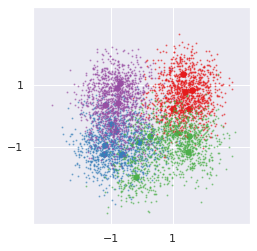

In [11]:
n_clusts=4
n_dists_per_clust=5
d=2
n_per_dist=250
dist_cov=0.25
clust_cov=0.25

colors = sns.color_palette("Set1", n_colors=n_clusts)

means_and_samples = generate_hierarchical_gaussian_data(None, n_clusts, n_dists_per_clust, d, clust_cov, n_per_dist, dist_cov)
fig, ax = plt.subplots(1,1)

ax.set_ylim(-3.5,3.5)
ax.set_xlim(-3.5,3.5)

ax.set_aspect('equal')

for i, data in enumerate(means_and_samples):
    for j, clust in enumerate(data):
        for k, plot in enumerate(clust):
            if i == 0:
                ax.scatter(plot[0], plot[1], color=colors[j], alpha=1, s=30)
            else:
                ax.scatter(plot[:, 0], plot[:, 1], color=colors[j], alpha=1/2, s=1)
                
ax.set_yticks([-1, 1])
ax.set_xticks([-1, 1])

In [217]:
np.random.seed(2)

n_clusts=4
n_dists_per_clust=[2,5,10]
d=2
# n_per_dists=[25, 50, 100, 250]
n_per_dists = 25
dist_cov=1
clust_covs=[0.01, 0.05,
            0.1, 0.5,
            1, 5,
           10, 50]

# clust_covs=[0.001, 0.0025, 0.005, 
#             0.01, 0.025 ,0.05, 
#             0.1, 0.25, 0.5, 
#             1, 2.5, 5, 
#             10]

dissimilarity='eucl-means'

make_symmetric=True
scale=False
aug_diag=False
prep_params = (make_symmetric, scale, aug_diag)

embedding=None
embedding_kwargs={'n_components':2}
cluster=GMM
cluster_kwargs={'min_components':1, 'max_components':8}
cluster_params = (embedding, embedding_kwargs, cluster, cluster_kwargs)

f=ARI
calculate_random=True
random_nmc=500
eval_params = (f, calculate_random, random_nmc)

n_test_per_dist=250
n_trees_coarse=25
n_trees_fine=10
train_flat=True
acc_params = (n_test_per_dist, n_trees_coarse, n_trees_fine, train_flat)

#-
n_cores=90
n_mc = 500

evals = np.zeros((len(n_dists_per_clust), len(clust_covs), 2, n_mc))
accs = np.zeros((len(n_dists_per_clust), len(clust_covs), 3, n_mc))

for i, n in enumerate(tqdm(n_dists_per_clust)):
    for j, clust_cov_ in enumerate(tqdm(clust_covs)):
        data_params = (None, n_clusts, n, d, clust_cov_, n_per_dist, dist_cov)

        condensed_func = lambda x: hierarchical_gaussian_exp(*data_params, 
                                                   dissimilarity, 
                                                   *prep_params, 
                                                   *cluster_params, 
                                                   *eval_params)
        temp_list = Parallel(n_jobs=n_cores)(delayed(condensed_func)(tuple_) for tuple_ in np.zeros(n_mc))
        for _, list_ in enumerate(temp_list):
            evals[i,j,:,_]=list_[0]
            accs[i,j,:,_]=list_[1]

100%|██████████| 3/3 [8:11:45<00:00, 9835.19s/it]


In [29]:
import pickle

update_accs = False
update_evals = False

if update_accs:
    pickle.dump(accs, open('gaussian_simulations_accuracies.pkl', 'wb'))
else:
    accs = pickle.load(open('gaussian_simulations_accuracies.pkl', 'rb'))
    
if update_evals:
    pickle.dump(evals, open('gaussian_simulations_evals.pkl', 'wb'))
else:
    evals = pickle.load(open('gaussian_simulations_evals.pkl', 'rb'))

Text(0.475, 0.05, 'Coordinate variance of Type II distribution')

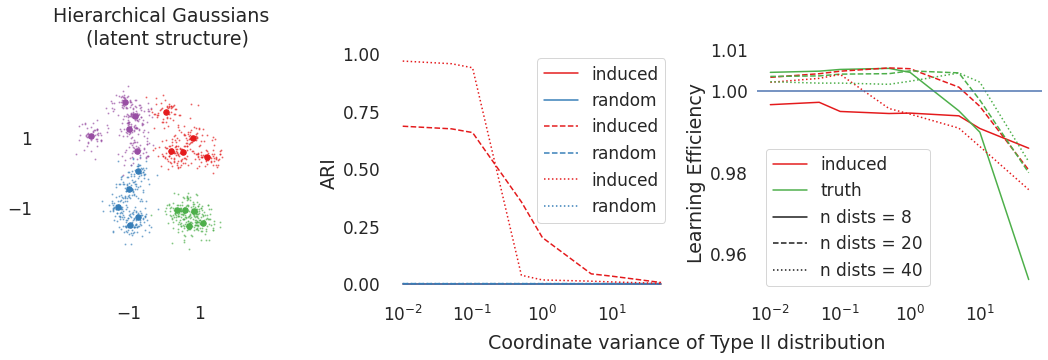

In [218]:
np.random.seed(2)
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.set_style('white')

n_clusts=4
n_dists_per_clust=[2,5,10]
d=2
n_per_dist=50
dist_cov=1
clust_cov=

fontsize_labels = 19
fontsize_legend=17
labelsize=17

colors = sns.color_palette("Set1", n_colors=6)

means_and_samples = generate_hierarchical_gaussian_data(None, n_clusts, n_dists_per_clust[1], d, clust_cov, n_per_dist, dist_cov)

for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
    ax_.spines['bottom'].set_visible(False)
    ax_.spines['left'].set_visible(False)

ax[0].set_ylim(-3.5,3.5)
ax[0].set_xlim(-3.5,3.5)

ax[0].set_aspect('equal')

for i, data in enumerate(means_and_samples):
    for j, clust in enumerate(data):
        for k, plot in enumerate(clust):
            if i == 0:
                ax[0].scatter(plot[0], plot[1], color=colors[j], alpha=1, s=30)
            else:
                ax[0].scatter(plot[:, 0], plot[:, 1], color=colors[j], alpha=1/2, s=1)
                
ax[0].set_yticks([-1, 1])
ax[0].set_xticks([-1, 1])

ax[0].tick_params(labelsize=labelsize)

ax[0].set_title('Hierarchical Gaussians \n (latent structure)', fontsize=fontsize_labels)

mean_evals = np.mean(evals, axis=-1)

removed=-(len(clust_covs))

ls = ['-', '--', ':', '-.']
for i, n in enumerate(n_dists_per_clust):
    ax[1].semilogx(clust_covs[:-removed], mean_evals[i, :-removed, 0], color=colors[0], ls=ls[i], label='induced')
    ax[1].semilogx(clust_covs[:-removed], mean_evals[i, :-removed, 1], color=colors[1], ls=ls[i], label='random')
#     else:
#         ax[1].semilogx(clust_covs, mean_evals[i, :, 0], color=colors[0], ls=ls[i])
#         ax[1].semilogx(clust_covs, mean_evals[i, :, 1], color=colors[1], ls=ls[i])
            

ax[1].set_ylabel('ARI', fontsize=fontsize_labels)
# ax[1].set_xlabel('Coord. variance of Type II distribution', fontsize=fontsize_labels)

# ax[1].set_title('NMI vs Coordinate variance for GMM o CMDS o L2', fontsize=fontsize_labels)

ax[1].set_xticks(clust_covs[:-removed])
ax[1].legend(fontsize=fontsize_legend)
ax[1].set_yticks([0.0, 0.25, 0.5, 0.75, 1])

ax[1].tick_params(labelsize=labelsize)

mean_accs = np.mean(accs, axis=-1)
# learning_effs_induced = np.mean((1 - mean_accs[:, 1]) / (1 - mean_accs[:, 2]))
# learning_effs_truth = np.mean((1 - mean_accs[:, 0]) / (1 - mean_accs[:, 2])) 

# std_les_induced = np.sqrt(learning_effs_induced) / np.sqrt(n_per_dist)
# std_les_truth = np.sqrt(learning_effs_truth) / np.sqrt(n_per_dist)

ax[2].set_xscale('log')

for i, n in enumerate(n_dists_per_clust):
    if i == 0:
        ax[2].plot(clust_covs[:-removed], (1 - mean_accs[i, :-removed, 2]) / (1 - mean_accs[i, :-removed, 1]), 
                        color=colors[0], ls=ls[i], label='induced')
        ax[2].plot(clust_covs[:-removed], (1 - mean_accs[i, :-removed, 2]) / (1 - mean_accs[i, :-removed, 0]), 
                        color=colors[2], ls=ls[i], label='truth')
    else:
        ax[2].plot(clust_covs[:-removed], (1 - mean_accs[i, :-removed, 2]) / (1 - mean_accs[i, :-removed, 1]), 
                        color=colors[0], ls=ls[i])
        ax[2].plot(clust_covs[:-removed], (1 - mean_accs[i, :-removed, 2]) / (1 - mean_accs[i, :-removed, 0]), 
                        color=colors[2], ls=ls[i])
    
    ax[2].axhline(y=0, c='k', ls=ls[i], label='n dists = %i'%(n*4))
#         ax[2].errorbar(clust_covs[:-removed], ((1 - mean_accs[:-removed, 0]) / (1 - mean_accs[:-removed, 2])),
#                       yerr=std_accs)

#         ax[2].plot(clust_covs[:-removed], mean_accs[:-removed, 0], label='truth') 
#         ax[2].plot(clust_covs[:-removed], mean_accs[:-removed, 1], label='induced') 
#         ax[2].plot(clust_covs[:-removed], mean_accs[:-removed, 2], label='flat') 
            #                         color=colors[0], ls=ls[i], label='induced')
#         ax[2].plot(clust_covs[:-removed], ((1 - mean_accs[:-removed, 0]) / (1 - mean_accs[:-removed, 2])), 
#                         color=colors[2], ls=ls[i], label='truth')

#         ax[2].plot(clust_covs[:-removed], learning_effs_induced[:-removed], colors=colors[0], label='induced')
        
#         ax[2].semilogx(clust_covs[:-removed], mean_accs[i, :-removed, 0], color=colors[2], ls=ls[i], label='truth')
#         ax[2].semilogx(clust_covs[:-removed], mean_accs[i, :-removed, 2], color=colors[1], ls=ls[i], label='flat')
#     else:
#         ax[2].semilogx(clust_covs, mean_accs[i, :, 1], color=colors[0], ls=ls[i])
#         ax[2].semilogx(clust_covs, mean_accs[i, :, 0], color=colors[1], ls=ls[i])
#         ax[2].semilogx(clust_covs, mean_accs[i, :, 2], color=colors[2], ls=ls[i])
            

ax[2].set_ylabel('Learning Efficiency', fontsize=fontsize_labels)
# ax[2].set_xlabel('Coord. variance of Type II distribution', fontsize=fontsize_labels)

# ax[2].set_title('Accuracy vs Coordinate variance for GMM o CMDS o L2', fontsize=fontsize_labels)

ax[2].set_xticks(clust_covs[:-removed])
ax[2].tick_params(labelsize=labelsize)
# ax[2].set_yticks([0.08, 0.12, 0.16])

# ax[2].axhline(y=1, label='flat')
ax[2].set_yticks([0.96, 0.98, 1, 1.01])
ax[2].set_ylim(0.95,1.01)
ax[2].legend(fontsize=fontsize_legend)
ax[2].axhline(y=1, label='flat')
# ax[1].set_aspect('equal')


plt.tight_layout()
fig.subplots_adjust(bottom=0.2) 
plt.figtext(x=0.475, y=0.05, s='Coordinate variance of Type II distribution', fontsize=fontsize_labels)
# plt.savefig('figures/nmi_accuray_gmm_cmds_l2_learning_efficiency.png')
# plt.savefig('figures/nmi_accuray_gmm_cmds_l2_learning_efficiency.pdf')